Google Drive Authentication
---

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/IIC/

Mounted at /gdrive
/gdrive/My Drive/DrRabiee-Project


Importing/Installing the Necessary Libraries
---

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 5.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491627 sha256=877ee660dd54d20e475ba529c3d8e168c182d27c6ea00eec086f960cd34186b8
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
from __future__ import print_function
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow import expand_dims
import numpy as np
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import shap
from skimage.segmentation import slic
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pylab as pl
import random
import bottleneck as bn
from sklearn.metrics import accuracy_score
from PIL import Image

Configuration
---

In [ ]:
num_classes = 10
weight_decay = 0.0005
x_shape = [32,32,3]
batch_size = 128
maxepoches = 250
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

Model Architecture
---

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same',
                    input_shape=x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

Loading the Model
---

In [ ]:
model.load_weights('models/cifar10.h5')

Classify Custom Pictures
---

In [ ]:
def normalize_one_img(img):
    mean = 120.707
    std = 64.15
    img = (img-mean)/(std+1e-7)
    return img

In [ ]:
def classify_img(model, img, normalize=True):
    # normalize only if you're working with a true image outside of the 
    img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
    mean = 120.707
    std = 64.15
    img = (img-mean)/(std+1e-7) if normalize==True else img
    pred = model(img)[0]
    class_idx = np.argmax(pred)
    idx2name = {0:'airplane', 1:'car', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
    return idx2name[class_idx]

Loading the Data
---

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

170500096/170498071 [==============================] - 3s 0us/step


Normalizing the Data
---

In [ ]:
def normalize(X_train,X_test):
    # this function normalizes inputs so that they have zero mean and unit variance
    # it is used when training a model
    # Input: training set and test set
    # Output: normalized training set and test set according to the trianing set statistics.
    mean = np.mean(X_train,axis=(0,1,2,3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    return X_train, X_test

In [ ]:
x_train, x_test = normalize(x_train, x_test)

Performing one-hot encoding on the labels
---

In [ ]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Kernel SHAP
---

In [ ]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

In [ ]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out

In [ ]:
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

In [ ]:
feature_names = {'0':['n1','airplane'], '1':['n2','car'], '2':['n3','bird'], '3':['n4','cat'], '4':['n5','deer'], '5':['n6','dog'], '6':['n7','frog'], '7':['n8','horse'], '8':['n9','ship'], '9':['n10','truck']}

In [ ]:
def cifar_to_pil(img):
    img = img*255
    PIL_image = Image.fromarray(np.uint8(img)).convert('RGB')
    return PIL_image

In [ ]:
def get_shap_values(img_orig, model, num_segments=50):
    def f(z):
        return model.predict(mask_image(z, segments_slic, img_orig, 255))

    img = cifar_to_pil(img_orig)
    segments_slic = slic(img, n_segments=num_segments, compactness=30, sigma=3)
    explainer = shap.KernelExplainer(f, np.zeros((1,num_segments)))
    shap_values = explainer.shap_values(np.ones((1,num_segments)), nsamples=1000)
    preds = model.predict(np.expand_dims(img_orig.copy(), axis=0))
    top_preds = np.argsort(-preds)
    return img, segments_slic, shap_values, top_preds

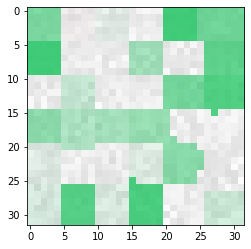

In [ ]:
img_orig = x_test[2500]
img, segments_slic, shap_values, top_preds = get_shap_values(img_orig, model)
num_top_pred = 0
m = fill_segmentation(shap_values[top_preds[0][num_top_pred]][0], segments_slic)
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
plt.imshow(img.convert('LA'), alpha=0.15)
plt.imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)

In [ ]:
def get_heatmap(input_img, model):
    img_orig = input_img
    img, segments_slic, shap_values, top_preds = get_shap_values(img_orig, model)
    max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
    num_top_pred = 0
    heatmap = fill_segmentation(shap_values[top_preds[0][num_top_pred]][0], segments_slic)
    return heatmap

In [ ]:
# the following function gets the top n elements (in terms of magnitude) from a numpy array
def top_n_indexes(arr, n):
    idx = bn.argpartition(arr, arr.size-n, axis=None)[-n:]
    width = arr.shape[1]
    return [divmod(i, width) for i in idx]

In [ ]:
# given a list of tuples (pixel indices), this function generates a list of other pixels
def get_other_pixels(idx_list):
    idx_list = set(idx_list)
    other_pixels = []
    for i in range(28):
        for j in range(28):
            if (i,j) not in idx_list:
                other_pixels.append((i,j))
    return other_pixels

In [ ]:
# given an image and a heatmap showing the importance of each pixels, this function destructs the image such that only a specified percentage of
# the most important pixels remains, and the other ones get replaced by salt and pepper noise
def destruct_image(img, heatmap, percentage=0.2):
    result = img.copy()
    idx_list = top_n_indexes(heatmap, int(percentage*(28*28)))
    idx_list.sort(key = lambda tup: tup[0])
    other_pixels = get_other_pixels(idx_list)
    for idx in other_pixels:
        # random_val = random.sample([0,1], 1)[0]
        random_val = 0
        result[idx[0],idx[1],0] = random_val
        result[idx[0],idx[1],1] = random_val
        result[idx[0],idx[1],2] = random_val
    return result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


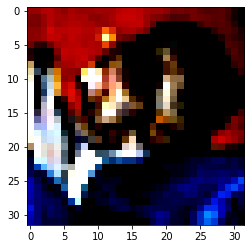

In [ ]:
plt.imshow(x_test[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


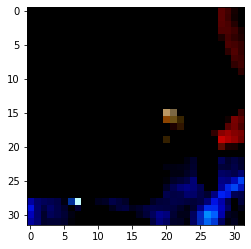

In [ ]:
plt.imshow(destruct_image(x_test[0], get_heatmap(x_test[0], model), 0.2))

In [ ]:
num_samples = 1000

In [ ]:
new_x_test = []
for curr_img in x_test[:num_samples]:
    curr_heatmap = get_heatmap(curr_img, model)
    new_img = destruct_image(curr_img, curr_heatmap, 0.2)
    new_x_test.append(new_img)
new_x_test = np.array(new_x_test)

In [ ]:
new_predictions = model.predict(new_x_test)

In [ ]:
new_predictions = list(np.argmax(new_predictions, axis=1))
true_labels = list(np.argmax(y_test[:num_samples], axis=1))

In [ ]:
accuracy_score(true_labels, new_predictions)

0.162